In [246]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import functools as ft

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
XY = np.loadtxt('dane.data')
print(XY[0])
print(XY.shape)

[-10.   -3.    2.   -1.   47.   -1.   17.  244.6]
(1999, 8)


> Popatrzmy na dane

In [3]:
df = pd.DataFrame(data=XY, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])

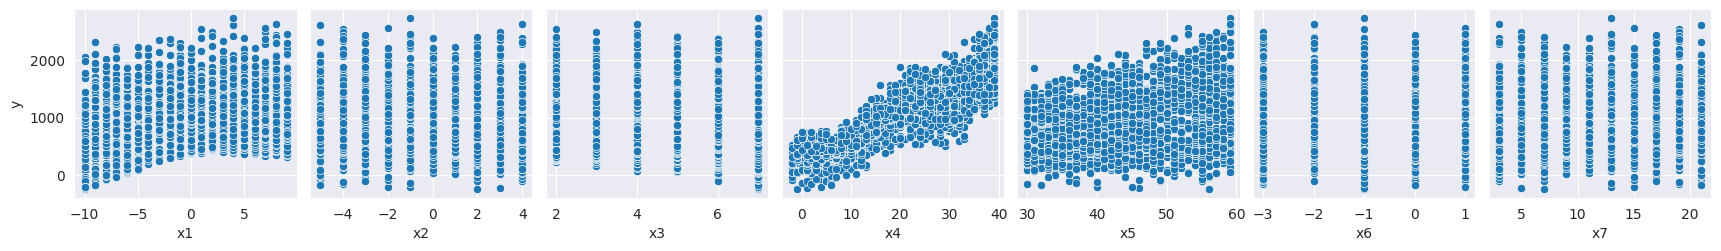

In [4]:
grid = sns.pairplot(df, x_vars=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], y_vars=['y'])

<Axes: >

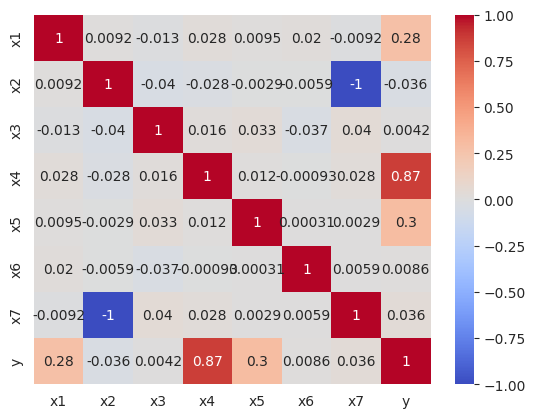

In [5]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

> x1, x4 i x5 układają się w jakąś prostą względem y \
> reszta danych pewnie potrzebuje jakichś transformacji \
> x7 i x2 bardzo ciekawa korelacja

In [6]:
from utilz import divide_dataset

T = 10 # numer of iterations

# and some constants
K = 3000
STEPS_TO_PLOT = 30
EPSILON = 1e-5

datasets = []
for i in range(T):
    datasets.append(
        divide_dataset(
            XY.copy(),
            fractions_train_val_test=[0.6, 0.2, 0.2]))

> Robimy 10 podziałów na train, val i test

In [7]:
from utilz import run_linear_regression_model
from linear_regression import basic_analytic_linear_regression
from loss import ols

theta, error, history, training = run_linear_regression_model(
    ft.partial(basic_analytic_linear_regression, bias=False),
    ols,
    datasets,
    standardize=False,
    use_test=False)

print(f"Theta no bias:\n{theta}")
print(f"Error no bias: {error}")

Theta no bias:
[[  23.66481074]
 [-101.57214138]
 [  -6.4955352 ]
 [  39.05172156]
 [  18.73454601]
 [  -0.83903229]
 [ -49.51156464]]
Error no bias: 14883.71537524796


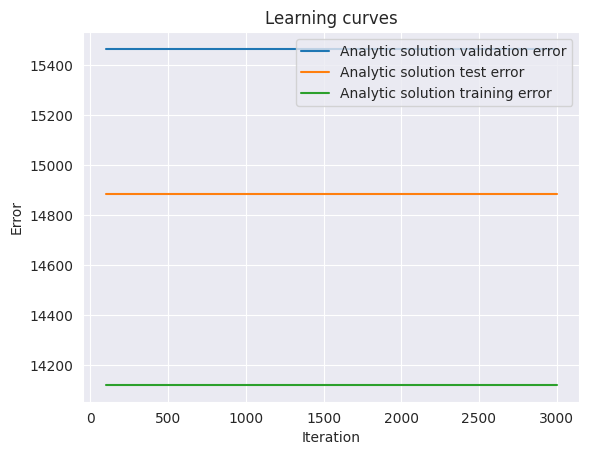

In [8]:
steps = np.arange(K // STEPS_TO_PLOT, K + 1, K // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history, ax = ax, label='Analytic solution validation error')
sns.lineplot(x = steps, y = error, ax = ax, label='Analytic solution test error')
sns.lineplot(x = steps, y = training, ax = ax, label='Analytic solution training error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

In [9]:
theta_bias, error_bias, history_bias, training_bias = run_linear_regression_model(
    ft.partial(basic_analytic_linear_regression, bias=True),
    ols, datasets,
    standardize=False)
print(f"Theta bias:\n{theta_bias}")
print(f"Error bias: {error_bias}")

Theta bias:
[[-22.05725652]
 [ 23.66481074]
 [-97.5617311 ]
 [ -6.4955352 ]
 [ 39.05172156]
 [ 18.73454601]
 [ -0.83903229]
 [-47.5063595 ]]
Error bias: 14883.715375247648


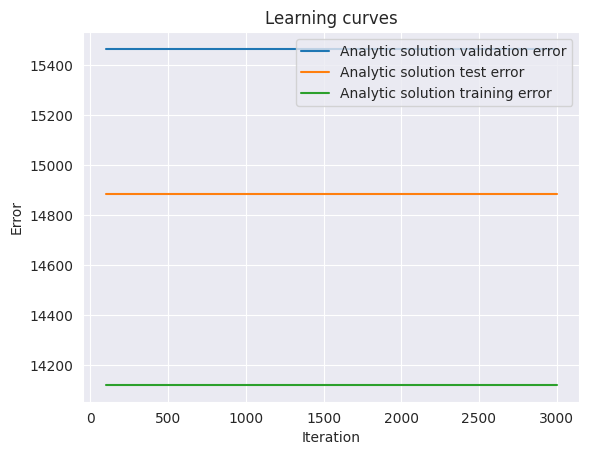

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history, ax = ax, label='Analytic solution validation error')
sns.lineplot(x = steps, y = error, ax = ax, label='Analytic solution test error')
sns.lineplot(x = steps, y = training, ax = ax, label='Analytic solution training error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

> Ten error jest przerażający, ale to przez OLS \
> Co mnie bardziej niepokoi, to że nie ma różnicy między bias=True i bias=False \
> Zobaczmy co na to scikit-learn

In [11]:
from utilz import run_linear_regression_model
from sklearn.linear_model import LinearRegression
from loss import ols

model = LinearRegression(fit_intercept=True)

theta_scikit, error_scikit, _, _ = run_linear_regression_model(
    lambda X, y, X_val, y_val:
        (np.c_[model.fit(X, y).intercept_, model.coef_].T, [], []),
    ols,
    datasets,
    standardize=False
)

print(f"Theta scikit bias:\n{theta_scikit}")
print(f"Error scikit bias: {error_scikit}")

Theta scikit bias:
[[-5.55842864e+02]
 [ 2.36648107e+01]
 [-5.09802419e-01]
 [-6.49553520e+00]
 [ 3.90517216e+01]
 [ 1.87345460e+01]
 [-8.39032286e-01]
 [ 1.01960484e+00]]
Error scikit bias: 14883.715375247619


In [12]:
model = LinearRegression(fit_intercept=False)
theta_scikit_no_bias, error_scikit_no_bias, _, _ = run_linear_regression_model(
    lambda X, y, X_val, y_val: (model.fit(X, y).coef_.T, [], []),
    ols,
    datasets,
    standardize=False)

print(f"Theta scikit no bias:\n{theta_scikit_no_bias}")
print(f"Error scikit no bias: {error_scikit_no_bias}")

Theta scikit no bias:
[[  23.66481074]
 [-101.57214138]
 [  -6.4955352 ]
 [  39.05172156]
 [  18.73454601]
 [  -0.83903229]
 [ -49.51156464]]
Error scikit no bias: 14883.715375247597


> Te dane są tak misternie dobrane :| \
> W dalszej części wszystko domyślnie z bias=True

> Przed skalowanie sprawdźmy, czy umiem liczyć gradient

In [13]:
from utilz import run_linear_regression_model
from linear_regression import GD_OLS_finite_difference_linear_regression
from loss import ols

theta_GD_fd, error_GD_fd, _, _ = run_linear_regression_model(
    ft.partial(GD_OLS_finite_difference_linear_regression, alpha=0.0001, k=K, epsilon=EPSILON),
    ols,
    datasets,
    bias=True,
    standardize=False)

print(f"Theta GD fd:\n{theta_GD_fd}")
print(f"Error GD fd: {error_GD_fd}")

Theta GD fd:
[[ -4.16002305]
 [ 23.99525669]
 [-17.34229611]
 [-15.16429838]
 [ 37.43039387]
 [ 11.36606135]
 [  2.18300526]
 [-11.07566144]]
Error GD fd: 16019.32066224401


In [14]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD

theta_GD, error_GD, history_GD, training_GD = run_linear_regression_model(
    ft.partial(GD_linear_regression, grad=GD, alpha=0.0001, k=K, steps=STEPS_TO_PLOT),
    ols,
    datasets,
    bias=True,
    standardize=False)

print(f"Theta GD:\n{theta_GD}")
print(f"Error GD: {error_GD}")

Theta GD:
[[ -4.16002306]
 [ 23.99525669]
 [-17.34229612]
 [-15.16429836]
 [ 37.43039387]
 [ 11.36606135]
 [  2.18300526]
 [-11.07566144]]
Error GD: 16019.320661642963


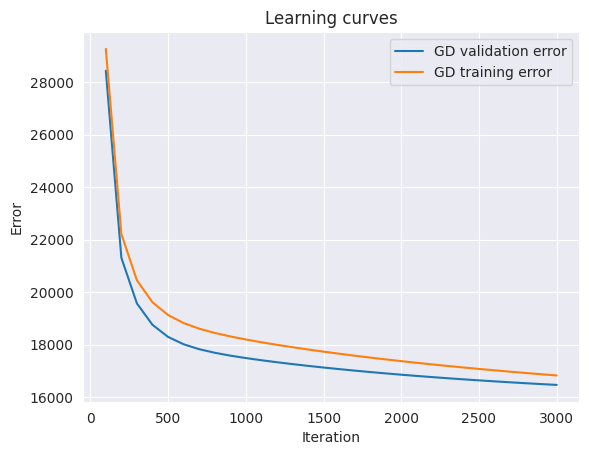

In [15]:
steps = np.arange(K // STEPS_TO_PLOT, K + 1, K // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_GD, ax = ax, label='GD validation error')
sns.lineplot(x = steps, y = training_GD, ax = ax, label='GD training error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

> Umiem liczyć gradient :) \
> Wszystko działa jak się da alpha/m z sumą bez mean, inaczej była eksplozja co ma sens

> To teraz czas na SGD

In [16]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD

theta_SGD, error_SGD, history_SGD, training_SGD = run_linear_regression_model(
    ft.partial(SGD_linear_regression, grad=GD, alpha=0.0001, k=K, batch_size=32, steps=STEPS_TO_PLOT),
    ols,
    datasets,
    bias=True,
    standardize=False)

print(f"Theta SGD:\n{theta_SGD}")
print(f"Error SGD: {error_SGD}")

Theta SGD:
[[-22.04663683]
 [ 23.68161276]
 [-97.51593416]
 [ -6.52104752]
 [ 39.0439617 ]
 [ 18.7006382 ]
 [ -0.83574504]
 [-47.48113684]]
Error SGD: 14941.158580967569


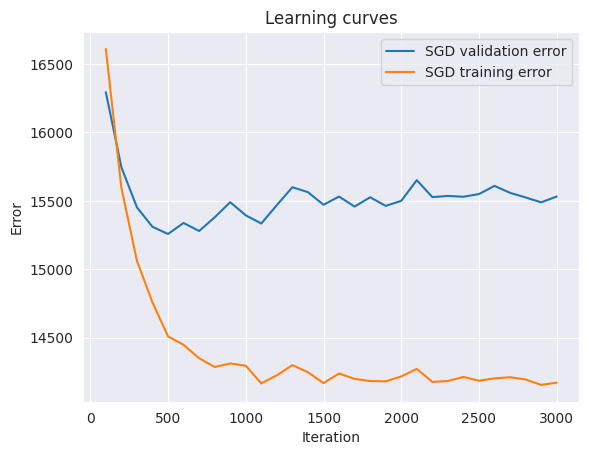

In [17]:
steps = np.arange(K // STEPS_TO_PLOT, K + 1, K // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD, ax = ax, label='SGD validation error')
sns.lineplot(x = steps, y = training_SGD, ax = ax, label='SGD training error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

> WOWOWO SGD jest świetny, prawie minimum

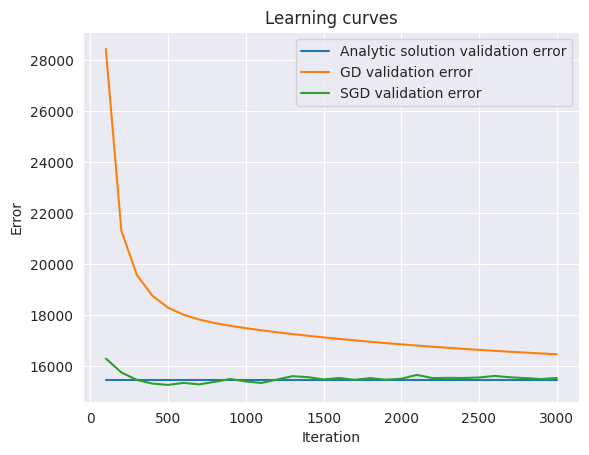

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_bias, ax = ax, label='Analytic solution validation error')
sns.lineplot(x = steps, y = history_GD, ax = ax, label='GD validation error')
sns.lineplot(x = steps, y = history_SGD, ax = ax, label='SGD validation error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

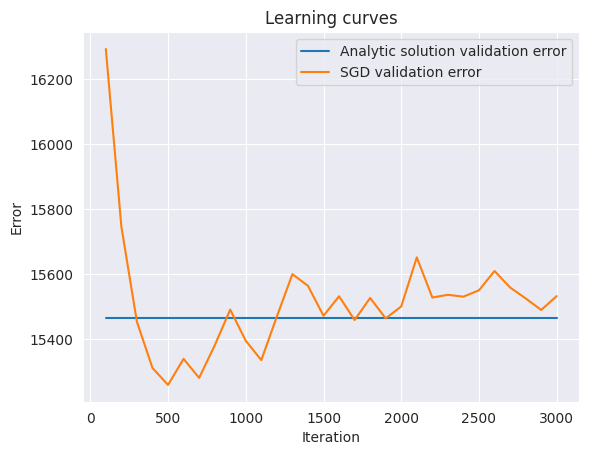

In [19]:
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_bias, ax = ax, label='Analytic solution validation error')
sns.lineplot(x = steps, y = history_SGD, ax = ax, label='SGD validation error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

> Bardzo piękny przykład czemu probabil jest genialny

> W poszukiwaniu dobrej alphy

In [36]:
K = 3000
STEPS_TO_PLOT = 30

In [37]:
from utilz import search_alpha
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD

alphas = [0.000001, 0.00001, 0.0001, 0.001]
search_alpha(ft.partial(GD_linear_regression, grad=GD, k=K), ols, datasets, alphas, standardize=False)

Alpha: 1e-06, validation error 57739.68566462274
Alpha: 1e-05, validation error 19570.969641279014
Alpha: 0.0001, validation error 16460.205993935866
Alpha: 0.001, validation error nan


In [38]:
from utilz import search_alpha
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD

alphas = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
search_alpha(ft.partial(GD_linear_regression, grad=GD, k=K), ols, datasets, alphas, standardize=False)

Alpha: 0.0002, validation error 15855.610853438866
Alpha: 0.0003, validation error 15547.028333862221
Alpha: 0.0004, validation error 15364.387745782045
Alpha: 0.0005, validation error 15261.581814338491
Alpha: 0.0006, validation error 15211.593399983676
Alpha: 0.0007, validation error 15195.398506661679
Alpha: 0.0008, validation error 1.489060659724989e+194
Alpha: 0.0009, validation error nan


> Super mamy alpha dla GD, to teraz SGD

In [39]:
from utilz import search_alpha
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD

alphas = [0.000001, 0.00001, 0.0001, 0.001]
search_alpha(ft.partial(SGD_linear_regression, grad=GD, k=K, batch_size=32), ols, datasets, alphas, standardize=False)

Alpha: 1e-06, validation error 17371.57091782663
Alpha: 1e-05, validation error 15385.848229302024
Alpha: 0.0001, validation error 15640.084590804934
Alpha: 0.001, validation error nan


> Widzimy, że SGD potrzebuje mniejszej alpha \
> A co z batch size?

In [41]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD

batch_sizes = [32, 64, 128, 256, 512]
for batch_size in batch_sizes:
    _, _, val_errors, _ = run_linear_regression_model(
        ft.partial(SGD_linear_regression, grad=GD, alpha=0.00001, k=K, batch_size=batch_size, steps=STEPS_TO_PLOT),
        ols,
        datasets,
        bias=True,
        standardize=False
    )
    print(f"Batch size: {batch_size}, error: {val_errors[-1]}")

Batch size: 32, error: 15402.334409756353
Batch size: 64, error: 15899.926128707937
Batch size: 128, error: 16459.61646504228
Batch size: 256, error: 17123.973753207796
Batch size: 512, error: 17579.636708945727


> Teraz chcielibyśmy umieć skalować dane \
> W sumie ja to  robię w odwrotnej kolejności, ale to tylko playground w mainie, bedzie lepiej

In [42]:
from utilz import search_alpha
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
search_alpha(ft.partial(GD_linear_regression, grad=GD, k=K), ols, datasets, alphas, standardize=True)

Alpha: 1e-05, validation error 565848.4430126951
Alpha: 0.0001, validation error 335838.43686996785
Alpha: 0.001, validation error 16942.634277634344
Alpha: 0.01, validation error 15464.28070735973
Alpha: 0.1, validation error 15464.280707360123
Alpha: 0.5, validation error 15464.280707360125
Alpha: 1, validation error 517976008.2309672


In [44]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD

# temporary
K = 40
STEPS_TO_PLOT = 40

theta_GD_S, error_GD_S, history_GD_S, training_GD_S = run_linear_regression_model(
    ft.partial(GD_linear_regression, grad=GD, alpha=0.1, k=K, steps=STEPS_TO_PLOT),
    ols,
    datasets,
    bias=True,
    standardize=True)

print(f"Theta GD scaled:\n{theta_GD_S}")
print(f"Validation Error GD scaled: {history_GD_S[-1]}")

Theta GD scaled:
[[955.91385248]
 [133.59506531]
 [ -3.62678262]
 [-10.27178176]
 [455.0050309 ]
 [160.34196055]
 [ -1.08983888]
 [  3.62678262]]
Validation Error GD scaled: 15607.39720302536


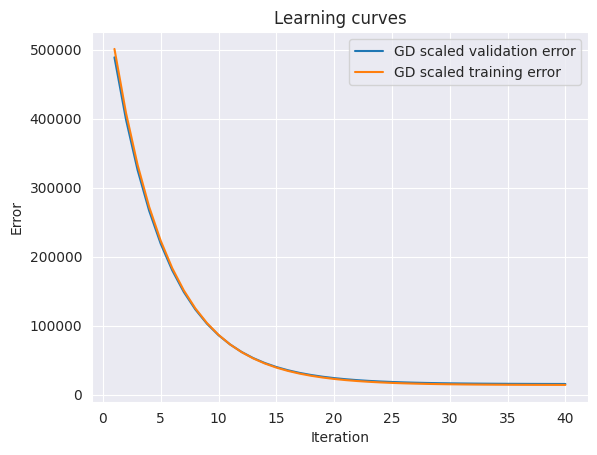

In [45]:
steps = np.arange(K // STEPS_TO_PLOT, K + 1, K // STEPS_TO_PLOT)
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_GD_S, ax = ax, label='GD scaled validation error')
sns.lineplot(x = steps, y = training_GD_S, ax = ax, label='GD scaled training error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

> Astronomicznie szybko zbiega \
> Trzeba wprowadzić częstsze monitorowanie

In [46]:
K = 100
STEPS_TO_PLOT = 100

In [47]:
from utilz import search_alpha
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
search_alpha(ft.partial(SGD_linear_regression, grad=GD, k=K, batch_size=32), ols, datasets, alphas, standardize=True)

Alpha: 1e-05, validation error 557103.3713839502
Alpha: 0.0001, validation error 288420.1861028864
Alpha: 0.001, validation error 15776.215542708309
Alpha: 0.01, validation error 15469.751734794441
Alpha: 0.1, validation error 15709.477772680237
Alpha: 0.5, validation error 18753.039965170436
Alpha: 1, validation error 101276.08751766753


In [48]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD

batch_sizes = [16, 32, 64, 128, 256, 512]
for batch_size in batch_sizes:
    _, _, val_errors, _ = run_linear_regression_model(
        ft.partial(SGD_linear_regression, grad=GD, alpha=0.01, k=K, batch_size=batch_size, steps=STEPS_TO_PLOT),
        ols,
        datasets,
        bias=True,
        standardize=True
    )
    print(f"Batch size: {batch_size}, validation error: {val_errors[-1]}")

Batch size: 16, validation error: 15471.38429662419
Batch size: 32, validation error: 15470.766145197747
Batch size: 64, validation error: 15468.125603990737
Batch size: 128, validation error: 15475.610054866858
Batch size: 256, validation error: 15497.978179390364
Batch size: 512, validation error: 16899.958904856623


In [70]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD

# temporary
K = 20
STEPS_TO_PLOT = 20

theta_SGD_S, error_SGD_S, history_SGD_S, training_SGD_S = run_linear_regression_model(
    ft.partial(SGD_linear_regression, grad=GD, alpha=0.01, k=K, batch_size=64, steps=STEPS_TO_PLOT),
    ols,
    datasets,
    bias=True,
    standardize=True,
    use_test=False)

print(f"Theta SGD scaled:\n{theta_SGD_S}")
print(f"Validation Error SGD scaled: {history_SGD_S[-1]}")

Theta SGD scaled:
[[948.94160205]
 [132.90189586]
 [ -3.57525187]
 [-10.04513428]
 [451.80694479]
 [159.26922309]
 [ -1.10489619]
 [  3.57525187]]
Validation Error SGD scaled: 15768.72797987179


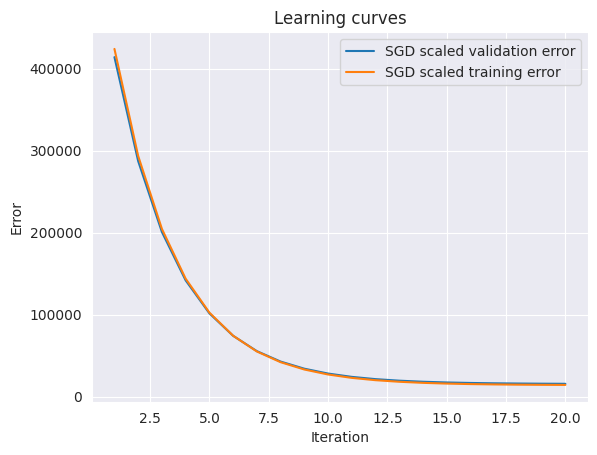

In [71]:
steps = np.arange(K // STEPS_TO_PLOT, K + 1, K // STEPS_TO_PLOT)
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD_S, ax = ax, label='SGD scaled validation error')
sns.lineplot(x = steps, y = training_SGD_S, ax = ax, label='SGD scaled training error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

> Niesamowite \
> K wyznaczyłem eksperymentalnie dlatego wypisuję validation error \
> Czuje, że będą zmiany w otrzymywaniu historii treningu \
> Dalej skupimy się na SGD

In [218]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_L2

# temporary
K = 100
STEPS_TO_PLOT = 100
lambdaa = 0.01

theta_L2_S, error_L2_S, history_L2_S, training_L2_S = run_linear_regression_model(
    ft.partial(SGD_linear_regression, grad=ft.partial(GD_L2, lambdaa=lambdaa),
               alpha=0.01,
               k=K,
               batch_size=64,
               steps=STEPS_TO_PLOT,
               loss=ols),
    ols,
    datasets,
    bias=True,
    standardize=True,
    use_test=False)

print(f"Theta L2 scaled:\n{theta_L2_S}")
print(f"Validation Error L2 scaled: {history_L2_S[-1]}")

Theta L2 scaled:
[[970.27146534]
 [132.34672584]
 [ -3.64618277]
 [-10.54638704]
 [452.70001026]
 [159.581407  ]
 [ -1.18312312]
 [  3.64618277]]
Validation Error L2 scaled: 15244.814343356245


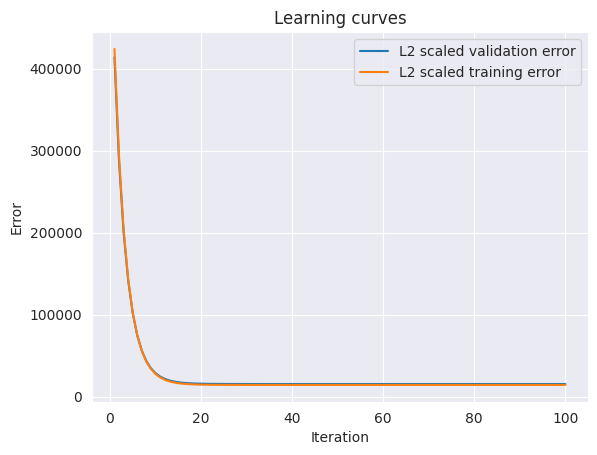

In [219]:
steps = np.arange(K // STEPS_TO_PLOT, K + 1, K // STEPS_TO_PLOT)
fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_L2_S, ax = ax, label='L2 scaled validation error')
sns.lineplot(x = steps, y = training_L2_S, ax = ax, label='L2 scaled training error')
ax.set(xlabel='Iteration', ylabel='Error')
ax.set_title('Learning curves')
plt.legend()

In [220]:
print(f"Test error SGD scaled: {error_SGD_S}")
print(f"Test error L2 scaled: {error_L2_S}")

Test error SGD scaled: 14992.315949634565
Test error L2 scaled: 14598.824876995172


> Podejrzane, sprawdzamy analitycznie

In [243]:
from utilz import run_linear_regression_model
from linear_regression import L2_analytic_linear_regression
from loss import ols

theta_L2_A, error_L2_A, history_L2_A, training_L2_A = run_linear_regression_model(
    ft.partial(L2_analytic_linear_regression,
               lambdaa=0.01,
               bias=True,
               loss=ols),
    ols,
    datasets,
    bias=True,
    standardize=True,
    use_test=False)

print(f"Theta analytic L2 scaled:\n{theta_L2_A}")
print(f"Training Error analytic L2 scaled: {training_L2_A}")
print(f"Training Error SGD L2 scaled: {training_L2_S[-1]}")

Theta analytic L2 scaled:
[[970.25507923]
 [134.63800082]
 [ -3.64809552]
 [-10.98889822]
 [461.68421833]
 [162.77215302]
 [ -1.20589995]
 [  3.64809551]]
Training Error analytic L2 scaled: 14120.079634408941
Training Error SGD L2 scaled: 14168.947495997281


> Czyli działa, tylko nie umiem uogólniać \
> Sprawdźmy, czy norma theta maleje

In [231]:
print(f"Norma theta GD L2 scaled: {np.linalg.norm(theta_SGD_S[1:])}")
print(f"Norma theta L2 scaled: {np.linalg.norm(theta_L2_S[1:])}")
print(f"Norma theta analytic L2 scaled: {np.linalg.norm(theta_L2_A[1:])}")

Norma theta GD L2 scaled: 497.2794034307795
Norma theta L2 scaled: 498.0546114144207
Norma theta analytic L2 scaled: 507.447560376791


> Lambda musi być spora, żeby to jakoś działało

In [244]:
from sklearn.linear_model import Ridge
from loss import ols
from utilz import run_linear_regression_model

lambdaa = 0.01

model = Ridge(alpha=lambdaa, fit_intercept=True)

theta_L2_scikit, error_L2_scikit, _, _ = run_linear_regression_model(
    lambda X, y, X_val, y_val:
        (np.r_[model.fit(X, y).intercept_, model.coef_].reshape(-1, 1), [], []),
    ols,
    datasets,
    bias=True,
    standardize=True
)

print(f"Error L2 scikit bias: {error_L2_scikit}")
print(f"Error L2 SGD bias: {error_L2_S}")
print(f"Error L2 analytic bias: {error_L2_A}")
print(f"Error SGD bias: {error_SGD_S}")
print(f"Norm theta L2 scikit bias: {np.linalg.norm(theta_L2_scikit[1:])}")


Error L2 scikit bias: 14883.572578371048
Error L2 SGD bias: 14598.824876995172
Error L2 analytic bias: 14883.572578363044
Error SGD bias: 14992.315949634565
Norm theta L2 scikit bias: 507.86150651573


> Znowu SGD pokazuje klasę